#**Installations**

In [ ]:
!pip install torchmetrics

#**Imports**

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from torchvision import transforms as T
import kagglehub
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset, DataLoader, random_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

#**Load Dataset**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:00<00:00, 157MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [ ]:
dataset_path = '/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1'

In [ ]:
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")

#**Visualizing Dataset**

In [ ]:
categories = ["glioma", "meningioma", "notumor", "pituitary"]

In [ ]:
# Load and preprocess the dataset
train_set = []
for category in categories:
    folder_path = os.path.join(train_path, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_set.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_set = pd.concat(train_set, ignore_index=True)

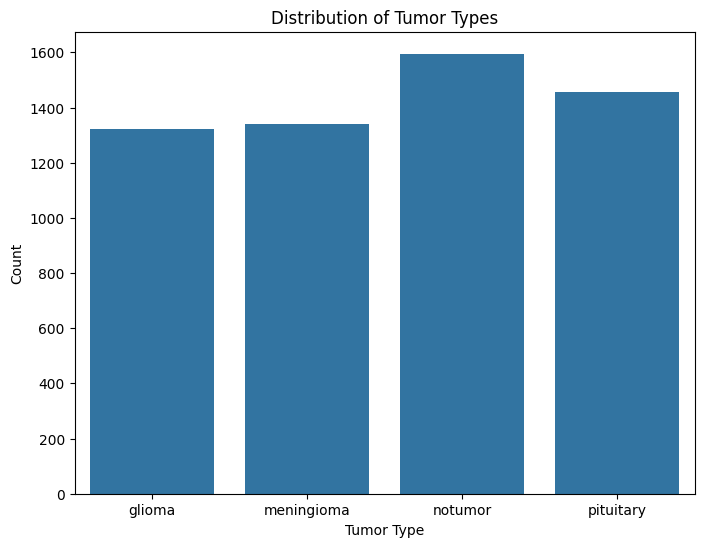

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=train_set, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

In [ ]:
transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_set = ImageFolder(train_path, transform=transform_train)
test_set = ImageFolder(test_path, transform=transform_test)

In [ ]:
train_loader = DataLoader(train_set, batch_size=32 ,shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)
print(y)

torch.Size([32, 3, 224, 224])
tensor([0, 1, 2, 1, 2, 1, 3, 3, 1, 3, 1, 2, 3, 1, 0, 0, 2, 3, 0, 3, 2, 1, 2, 0,
        3, 1, 2, 3, 1, 2, 0, 3])


In [ ]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')
    plt.tight_layout()

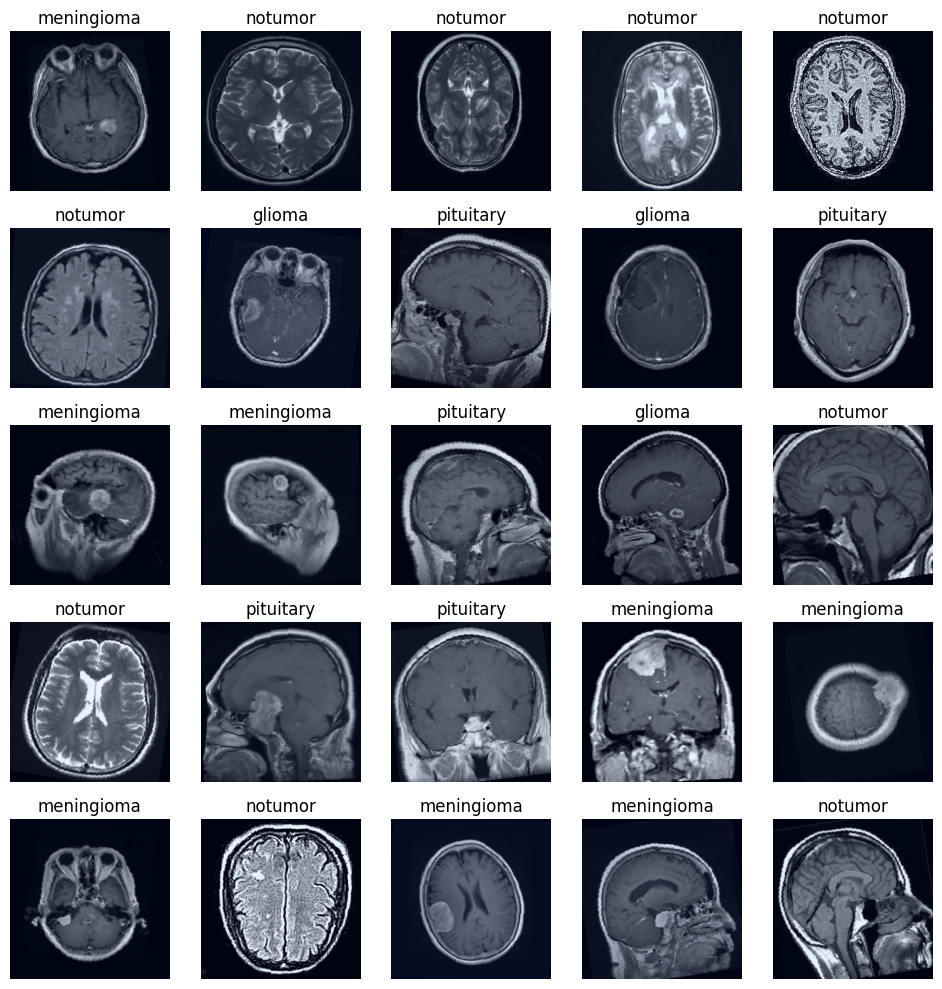

In [ ]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

#**Model**

In [ ]:
def conv3x3_bn_af(in_channels, out_channels):
    module = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )
    return module

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            conv3x3_bn_af(3, 16),
            conv3x3_bn_af(16, 16),
            nn.MaxPool2d(2, 2),

            conv3x3_bn_af(16, 32),
            conv3x3_bn_af(32, 32),
            nn.MaxPool2d(2, 2),

            conv3x3_bn_af(32, 56),
            conv3x3_bn_af(56, 56),
            nn.MaxPool2d(2, 2),

            conv3x3_bn_af(56, 128),
            conv3x3_bn_af(128, 128),
            nn.AdaptiveAvgPool2d(output_size=(1, 1))  # 1x1
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x) # outputs 4D tensor from the convolutional layers
        x = x.view(x.size(0), -1) # expects 1D tensor => x.size(0): Keeps the batch size unchanged.
                                                        # -1: Automatically flattens all remaining dimensions into a single vector.
        x = self.classifier(x)
        return x

# **Functions**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=num_classes).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=num_classes).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Setting Hyperparameters**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)
num_classes = 4
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(1.3566, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-1000, 1000))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

In [ ]:
num_epochs = 5

for lr in [0.08, 0.1, 0.2]:
  for wd in [1e-4, 1e-5, 0.]:
    model = CNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)
    print()

#**Training**

In [ ]:
model = CNN().to(device)
lr = 0.0001
wd = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 179/179 [00:56<00:00,  3.20batch/s, accuracy=65.8, loss=0.894]


Valid: Loss = 0.7587, Acc = 0.7285



Epoch 1: 100%|██████████| 179/179 [00:56<00:00,  3.18batch/s, accuracy=76.8, loss=0.69]


Valid: Loss = 0.661, Acc = 0.7628



Epoch 2: 100%|██████████| 179/179 [00:56<00:00,  3.19batch/s, accuracy=82.5, loss=0.565]


Valid: Loss = 0.5571, Acc = 0.8009



Epoch 3: 100%|██████████| 179/179 [00:55<00:00,  3.21batch/s, accuracy=84.4, loss=0.498]


Valid: Loss = 0.5217, Acc = 0.8207



Epoch 4: 100%|██████████| 179/179 [00:56<00:00,  3.18batch/s, accuracy=86.2, loss=0.449]


Valid: Loss = 0.5847, Acc = 0.7826



Epoch 5: 100%|██████████| 179/179 [00:56<00:00,  3.18batch/s, accuracy=87.2, loss=0.416]


Valid: Loss = 0.4733, Acc = 0.823



Epoch 6: 100%|██████████| 179/179 [00:56<00:00,  3.18batch/s, accuracy=87.5, loss=0.392]


Valid: Loss = 0.4413, Acc = 0.8276



Epoch 7: 100%|██████████| 179/179 [00:56<00:00,  3.16batch/s, accuracy=88.1, loss=0.364]


Valid: Loss = 0.4301, Acc = 0.8444



Epoch 8: 100%|██████████| 179/179 [00:56<00:00,  3.16batch/s, accuracy=88.8, loss=0.345]


Valid: Loss = 0.7468, Acc = 0.7735



Epoch 9: 100%|██████████| 179/179 [00:56<00:00,  3.14batch/s, accuracy=89.3, loss=0.333]


Valid: Loss = 0.3817, Acc = 0.8558



Epoch 10: 100%|██████████| 179/179 [00:56<00:00,  3.17batch/s, accuracy=89.8, loss=0.313]


Valid: Loss = 0.3451, Acc = 0.8795



Epoch 11: 100%|██████████| 179/179 [00:55<00:00,  3.20batch/s, accuracy=90, loss=0.297]


Valid: Loss = 0.3795, Acc = 0.8627



Epoch 12: 100%|██████████| 179/179 [00:55<00:00,  3.20batch/s, accuracy=90.5, loss=0.294]


Valid: Loss = 0.6527, Acc = 0.7704



Epoch 13: 100%|██████████| 179/179 [00:55<00:00,  3.20batch/s, accuracy=90.8, loss=0.279]


Valid: Loss = 0.331, Acc = 0.8833



Epoch 14: 100%|██████████| 179/179 [00:55<00:00,  3.21batch/s, accuracy=91.1, loss=0.273]


Valid: Loss = 0.5181, Acc = 0.8185



Epoch 15: 100%|██████████| 179/179 [00:55<00:00,  3.23batch/s, accuracy=91.7, loss=0.261]


Valid: Loss = 0.3354, Acc = 0.8688



Epoch 16: 100%|██████████| 179/179 [00:56<00:00,  3.19batch/s, accuracy=91.8, loss=0.257]


Valid: Loss = 0.3876, Acc = 0.8711



Epoch 17: 100%|██████████| 179/179 [00:56<00:00,  3.18batch/s, accuracy=92, loss=0.243]


Valid: Loss = 0.2912, Acc = 0.8978



Epoch 18: 100%|██████████| 179/179 [00:56<00:00,  3.19batch/s, accuracy=92.3, loss=0.238]


Valid: Loss = 0.308, Acc = 0.8802



Epoch 19: 100%|██████████| 179/179 [00:56<00:00,  3.16batch/s, accuracy=93, loss=0.226]


Valid: Loss = 0.3324, Acc = 0.881



Epoch 20: 100%|██████████| 179/179 [00:56<00:00,  3.16batch/s, accuracy=92.4, loss=0.224]


Valid: Loss = 0.3083, Acc = 0.8833



Epoch 21: 100%|██████████| 179/179 [00:56<00:00,  3.14batch/s, accuracy=92.8, loss=0.218]


Valid: Loss = 0.3602, Acc = 0.8673



Epoch 22: 100%|██████████| 179/179 [00:56<00:00,  3.17batch/s, accuracy=93.6, loss=0.202]


Valid: Loss = 0.2171, Acc = 0.9207



Epoch 23: 100%|██████████| 179/179 [00:56<00:00,  3.15batch/s, accuracy=93.4, loss=0.195]


Valid: Loss = 0.3178, Acc = 0.8818



Epoch 24: 100%|██████████| 179/179 [00:56<00:00,  3.16batch/s, accuracy=94, loss=0.19]


Valid: Loss = 0.2736, Acc = 0.8932



Epoch 25: 100%|██████████| 179/179 [00:56<00:00,  3.19batch/s, accuracy=93.9, loss=0.187]


Valid: Loss = 0.2301, Acc = 0.9115



Epoch 26: 100%|██████████| 179/179 [00:56<00:00,  3.19batch/s, accuracy=94.2, loss=0.181]


Valid: Loss = 0.245, Acc = 0.9085



Epoch 27: 100%|██████████| 179/179 [00:55<00:00,  3.20batch/s, accuracy=94, loss=0.183]


Valid: Loss = 0.1952, Acc = 0.9352



Epoch 28: 100%|██████████| 179/179 [00:56<00:00,  3.18batch/s, accuracy=94.3, loss=0.176]


Valid: Loss = 0.4527, Acc = 0.849



Epoch 29: 100%|██████████| 179/179 [00:55<00:00,  3.20batch/s, accuracy=94.3, loss=0.175]


Valid: Loss = 0.1991, Acc = 0.9207



# **Plot**

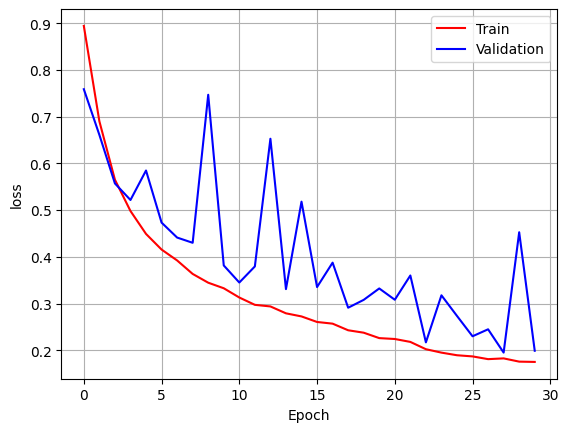

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

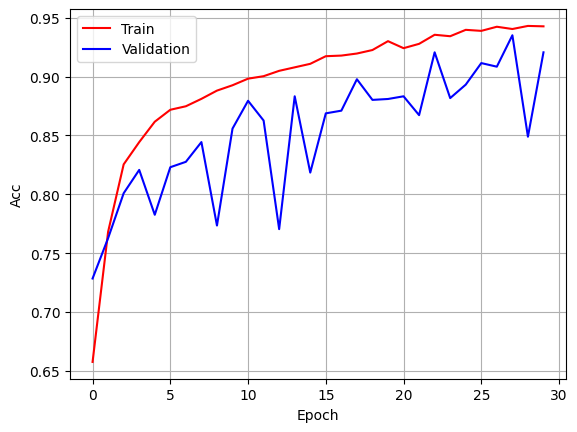

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

#**Model Evaluatio**

In [ ]:
# Set the model to evaluation mode
model.eval()

# Collect predictions and true labels
all_predictions = []
all_targets = []

# Disable gradient computation for inference
with torch.no_grad():
    for inputs, targets in test_loader:
        # Move data to the appropriate device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)  # Raw logits

        # Get predicted class (highest probability)
        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Convert to NumPy arrays for further evaluation
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

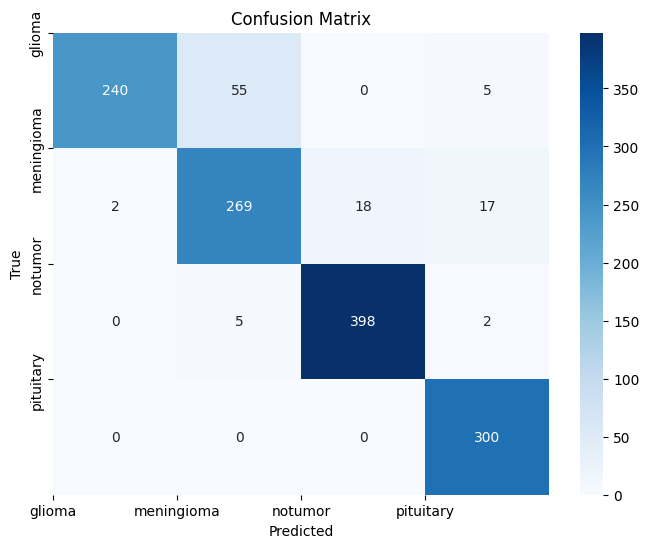

In [ ]:
predicted_categories = all_predictions
true_categories = all_targets

# Create a confusion matrix
conf_matrix = confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()